In [1]:
Hi Arran,

I've copied the 20/21 traverse data here:

/Volumes/arc_04/FIELD_DATA/K8622021/

Looks like metadata is in KIS\ Science/KIS_science.shp

Looks like the winter over station did well. Have a look at the point measurements when you get a chance and see if everything you are expecting is there.

On his own initiative all the stations were visited with the UC system. I'm hoping this doesn't cause any issues.

Cheers - Huw


SyntaxError: invalid syntax (<ipython-input-1-4802354451a7>, line 1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
import matplotlib as mpl

In [2]:
!ls /Volumes/arc_04/FIELD_DATA/K8622021/'KIS Science'/

'ApRES data files'
 ApRES_RESOURCES
 K862_2021_ShapeFiles
 K862A_2021_TraverseScience-compressed.pdf
'KIS2 New ApRES Trial Sub burst results'
'KIS2 WO GPS copy'
 KIS_science.cpg
 KIS_science.dbf
 KIS_science.prj
 KIS_science.qpj
 KIS_science.shp
 KIS_science.shx
'KSI1 Winterover ApRES Trial subburst.docx'


In [3]:
metadata = gpd.read_file("/Volumes/arc_04/FIELD_DATA/K8622021/KIS Science/KIS_science.shp")


In [4]:
metadata.query('(Data_type=="ApRES") & (Project=="KIS2")',inplace=True)

In [5]:
metadata.drop(columns=['id', 'Uni_Event', 'Data_type',
       'Flag1ht_cm', 'Flag2ht_cm',  'Project'], 
             inplace=True)

In [6]:
metadata.keys()

Index(['Date', 'AF_Gain', 'Burst', 'RF_Atten', 'Depth_m', 'Site_ID', 'Notes',
       'ApRes_Unit', 'File_Name', 'Y', 'X', 'geometry'],
      dtype='object')

In [7]:
metadata.rename(columns={"X":"lon","Y":"lat",'Burst':"Stacks","ApRes_Unit":"APRES_unit","Depth_m":"Approx_Depth"},inplace=True)

In [8]:
metadata['Epoch'] = 3
metadata['utc_time'] = np.nan

In [9]:
metadata['Site_ID'] = metadata.Site_ID.apply(lambda x: x.upper()).copy()

In [10]:
metadata.loc[61,['Site_ID']] ='CP07'

In [11]:
metadata.drop(columns=['geometry'],inplace=True)

In [12]:
metadata.head()

,Date,AF_Gain,Stacks,RF_Atten,Approx_Depth,Site_ID,Notes,APRES_unit,File_Name,lat,lon,Epoch,utc_time
35,2020-12-22,-4,64.0,20,770.0,CP34,F1=W. New site,"UC Antenna, UC unit SN-143",Survey_2020-12-22_035737.dat,-82.471847,-152.208053,3,NaN
36,2020-12-22,-4,64.0,21,665.0,CP33,"F1=W. Two sharp reflectors at 665m and 764m, s...","UC Antenna, UC unit SN-143",Survey_2020-12-22_042049.dat,-82.471548,-152.224309,3,NaN
37,2020-12-22,-4,64.0,20,566.0,CP32,"F1=W. Two sharp reflectors at 566m 765m, new site","UC Antenna, UC unit SN-143",Survey_2020-12-22_044149.dat,-82.471325,-152.238891,3,NaN
38,2020-12-22,-4,64.0,20,493.0,CP31,"F1=W. Two sharp reflectors at 493m, 758m , new...","UC Antenna, UC unit SN-143",Survey_2020-12-22_050111.dat,-82.471154,-152.257888,3,NaN
39,2020-12-22,-4,64.0,24,447.0,CP30,"F1=W, new site, sharp reflectors at 447m and 750m","UC Antenna, UC unit SN-143",Survey_2020-12-22_052753.dat,-82.471072,-152.278526,3,NaN


In [59]:
metadata.Site_ID.unique()

array(['CP34', 'CP33', 'CP32', 'CP31', 'CP30', 'CP_29_DRILL', 'CP28',
       'CP27', 'CP26', 'CP25', 'CP24', 'CP23', 'CP22', 'CP21', 'CP20',
       'CP19', 'CP15', 'CP18', 'CP16', 'CP17', 'CP11', 'CP10', 'CP09',
       'CP08', 'CP13', 'CP07', 'CP14', 'CP06', 'CP05', 'CP04', 'CP01',
       'CP02', 'CP03'], dtype=object)

In [14]:
metadata1920 = pd.read_csv("/Users/home/whitefar/DATA/ApRES/K862A1920ApRESSites_KIS2.csv")
metadata1920.keys()

Index(['SiteName', 'YYYYUTC', 'MTUTC', 'DDUTC', 'HHUTC', 'MNUTC', 'LATDD',
       'LATMM', 'LONDD', 'LONMM', 'FILE', 'Atten', 'Gain', 'Stacks', 'Epoch',
       'ApproxDepth', 'checked', 'comments'],
      dtype='object')

In [15]:
metadata1920['utc_datetime'] = pd.to_datetime({'year':metadata1920.YYYYUTC,
                           'month':metadata1920.MTUTC,
                            'day':metadata1920.DDUTC,
                               'hour':metadata1920.HHUTC,
                            'minute':metadata1920.MNUTC}).apply(lambda x: pd.Timestamp(x))

In [16]:
metadata1920['utc_time'] = metadata1920['utc_datetime'].apply(lambda x: x.isoformat())
metadata1920['Date'] =metadata1920['utc_datetime'].apply(lambda x: x.date())

In [17]:
metadata1920['lat'] = (metadata1920.LATDD - metadata1920.LATMM/60).round(decimals=6)
metadata1920['lon'] = (metadata1920.LONDD - metadata1920.LONMM/60).round(decimals=6)

In [18]:
metadata1920['APRES_unit'] = 'Huws_unit1'

In [19]:
metadata1920.rename(columns={"SiteName":"Site_ID","FILE":"File_Name","Gain":"AF_Gain","Atten":"RF_Atten","ApproxDepth":"Approx_Depth","comments":"Notes"},inplace=True)

In [20]:
metadata1920.drop(columns=['utc_datetime'],inplace=True)

In [21]:
metadata1920.keys()

Index(['Site_ID', 'YYYYUTC', 'MTUTC', 'DDUTC', 'HHUTC', 'MNUTC', 'LATDD',
       'LATMM', 'LONDD', 'LONMM', 'File_Name', 'RF_Atten', 'AF_Gain', 'Stacks',
       'Epoch', 'Approx_Depth', 'checked', 'Notes', 'utc_time', 'Date', 'lat',
       'lon', 'APRES_unit'],
      dtype='object')

In [22]:
metadata1920 = metadata1920[metadata.keys()].copy()

In [23]:
meta_out = pd.concat([metadata1920,metadata])

In [36]:
meta_out.drop([40],inplace=True)

In [37]:
meta_out.reset_index(drop=True,inplace=True)

In [38]:
meta_out.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch'],
      dtype='object')

In [39]:
meta_out = meta_out[['Date', 'utc_time', 'lat', 'lon','Approx_Depth','File_Name','AF_Gain', 'Stacks', 'RF_Atten',  'Site_ID',
       'Notes', 'APRES_unit',   'Epoch']]


In [40]:
meta_out.to_csv('/Users/home/whitefar/DATA/ApRES/kis2_apres_metadata.csv')

In [41]:
meta_out.Site_ID.unique()

array(['CP01', 'CP02', 'CP03', 'CP04', 'CP05', 'CP06', 'CP07', 'CP08',
       'CP09', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15', 'CP16',
       'CP17', 'CP18', 'CP19', 'CP20', 'CP21', 'CP22', 'CP23', 'CP24',
       'CP25', 'CP26', 'CP27', 'CP28', 'CP30', 'CP31', 'CP32', 'CP33',
       'CP34', 'CP_29_DRILL'], dtype=object)

In [42]:
meta_out.sort_values(by=['Site_ID','Epoch'],inplace=True)

In [43]:
meta_out.reset_index(drop=True,inplace=True)

In [44]:
meta_out.to_csv('/Users/home/whitefar/DATA/ApRES/kis2_apres_metadata_by_Site_ID.csv')

In [45]:
!ls /Volumes/arc_04/FIELD_DATA/K8622021/'KIS Science'/'ApRES data files'/KIS2

'KIS2 Old WO ApRES Card1'       Survey_2020-12-23_002658.dat
'KIS2 Old WO ApRES Card2'       Survey_2020-12-23_004352.dat
 Survey_2020-12-22_035737.dat   Survey_2020-12-23_010317.dat
 Survey_2020-12-22_042049.dat   Survey_2020-12-23_013605.dat
 Survey_2020-12-22_044149.dat   Survey_2020-12-23_015608.dat
 Survey_2020-12-22_050111.dat   Survey_2020-12-23_021900.dat
 Survey_2020-12-22_052753.dat   Survey_2020-12-23_023455.dat
 Survey_2020-12-22_201557.dat   Survey_2020-12-23_024953.dat
 Survey_2020-12-22_203746.dat   Survey_2020-12-23_030547.dat
 Survey_2020-12-22_205751.dat   Survey_2020-12-23_042754.dat
 Survey_2020-12-22_211915.dat   Survey_2020-12-23_045043.dat
 Survey_2020-12-22_213835.dat   Survey_2020-12-23_050820.dat
 Survey_2020-12-22_221342.dat   Survey_2020-12-23_052812.dat
 Survey_2020-12-22_223029.dat   Survey_2020-12-23_202213.dat
 Survey_2020-12-22_224858.dat   Survey_2020-12-23_204021.dat
 Survey_2020-12-22_230405.dat   Survey_2020-12-23_205701.dat
 Survey_2020-12-22_23324

In [46]:
meta_out.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch'],
      dtype='object')

In [47]:
# meta_out.iloc[40]

Date                       2019-12-08
utc_time          2019-12-08T03:16:00
lat                          -82.4656
lon                          -152.471
Approx_Depth                      521
File_Name       2019-12-08_030609.dat
AF_Gain                            -4
Stacks                             64
RF_Atten                           22
Site_ID                          CP15
Notes                             NaN
APRES_unit                 Huws_unit1
Epoch                               1
Name: 40, dtype: object

In [186]:
melt_rates = pd.read_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates.csv')
melt_rates.keys()

Index(['Var1', 'Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain', 'dheStrain'],
      dtype='object')

In [187]:
# df.loc[df['column_name'].isin(some_values)]
downchannel = ['CP07','CP16', 'CP17', 'CP18', 'CP19', 'CP20', 'CP21', 'CP22', 'CP23', 'CP24','CP25' ]

crosschannel = ['CP01', 'CP02', 'CP03', 'CP04', 'CP05', 'CP06', 'CP07', 'CP08',
       'CP09', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15' ]


In [188]:
melt_rates['cross_channel'] = melt_rates['Site_ID'].isin(crosschannel)
melt_rates['down_channel'] = melt_rates['Site_ID'].isin(downchannel)

In [189]:
# melt_rates = melt_rates.query('Epoch == 3').copy()

In [190]:
points = [Point(xy) for xy in zip(melt_rates.lon,melt_rates.lat) ]
gdf = gpd.GeoDataFrame(melt_rates,geometry=points,crs=4326)

In [191]:
gd = gdf.to_crs(3031)
gd['x']=gd.geometry.x
gd['y']=gd.geometry.y

In [192]:
gd.head()

,Var1,Date,utc_time,lat,lon,Approx_Depth,File_Name,AF_Gain,Stacks,RF_Atten,...,meltRate,meltRateError,bed,dhStrain,dheStrain,cross_channel,down_channel,geometry,x,y
0,0,2019-12-07,2019-12-07T23:03:00,-82.489493,-152.531345,710,2019-12-07_225600.dat,-4,64,20,...,NaN,NaN,NaN,NaN,NaN,True,False,POINT (-376925.062 -725034.465),-376925.062093,-725034.465287
1,1,NaT,NaT,-82.489493,-152.531345,710,2019-12-21_215758.dat,-4,64,20,...,NaN,NaN,NaN,NaN,NaN,True,False,POINT (-376925.062 -725034.465),-376925.062093,-725034.465287
2,2,2020-12-24,NaN,-82.489474,-152.531996,708,Survey_2020-12-23_202213.dat,-4,64,20,...,0.003546,0.012276,708.933784,-0.328751,0.012835,True,False,POINT (-376917.780 -725040.587),-376917.780305,-725040.587145
3,3,2019-12-07,2019-12-07T23:20:00,-82.484998,-152.520775,713,2019-12-07_231044.dat,-4,64,22,...,NaN,NaN,NaN,NaN,NaN,True,False,POINT (-377285.101 -725400.001),-377285.100817,-725400.001157
4,4,NaT,NaT,-82.484998,-152.520775,713,2019-12-21_221136.dat,-4,64,22,...,-0.023549,0.033077,714.742617,0.028749,0.001264,True,False,POINT (-377285.101 -725400.001),-377285.100817,-725400.001157


In [193]:
gd.drop(columns=['geometry']).to_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates.csv')

In [194]:
dc_m= gd.loc[gd['down_channel']==True].copy()
cc_m = gd.loc[gd['cross_channel']==True].copy()

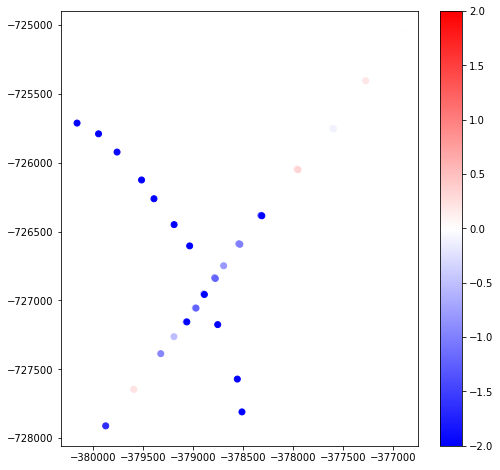

In [195]:
plt.figure(figsize=(8,8))
plt.scatter(gd.x,gd.y,c=gd.meltRate,cmap='bwr',vmin=-2,vmax=2)
plt.colorbar()
plt.show()

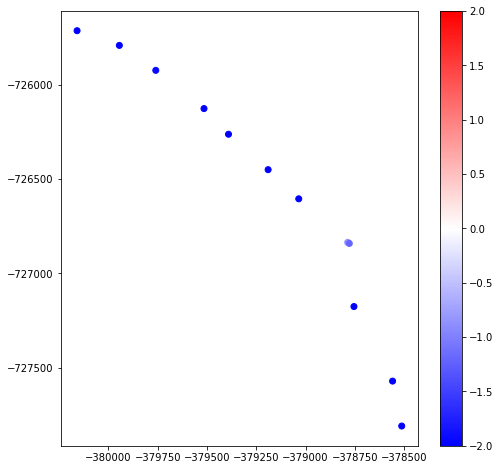

In [196]:
plt.figure(figsize=(8,8))
plt.scatter(dc_m.x,dc_m.y,c=dc_m.meltRate,cmap='bwr',vmin=-2,vmax=2)
plt.colorbar()
plt.show()

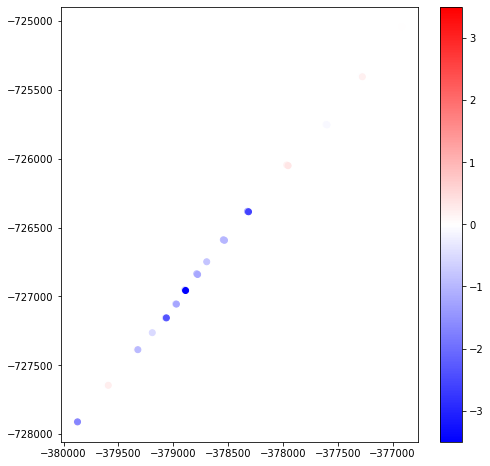

In [197]:
plt.figure(figsize=(8,8))
plt.scatter(cc_m.x,cc_m.y,c=cc_m.meltRate,cmap='bwr',vmin=-3.5,vmax=3.5)
plt.colorbar()
plt.show()

In [198]:
gd.sort_values(by=['x']).Site_ID

70    CP34
69    CP33
68    CP32
67    CP31
66    CP30
      ... 
3     CP02
5     CP02
1     CP01
0     CP01
2     CP01
Name: Site_ID, Length: 72, dtype: object

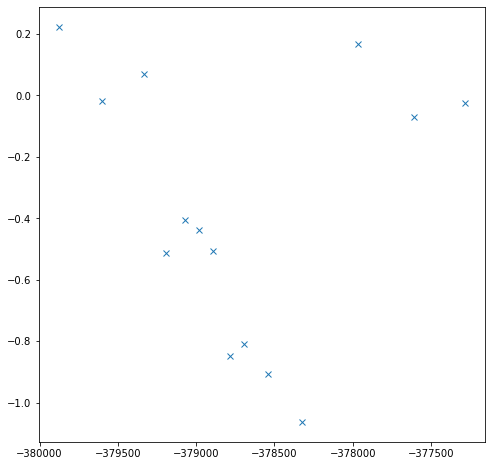

In [199]:
df_plot = cc_m.query('Epoch == 2')
plt.figure(figsize=(8,8))
plt.plot(df_plot.x,df_plot.meltRate,'x')
# plt.plot(cc_m.loc[melt_rates['Epoch']==2].x,cc_m.loc[melt_rates['Epoch']==2].meltRate,'o')
plt.show()

In [200]:
# plt.figure(figsize=(8,8))
# plt.scatter(melt_rates.lat,melt_rates.lon,c=melt_rates.meltRate,cmap='bwr',vmin=-2,vmax=2)
for i in range(melt_rates.shape[0]):
    plt.annotate( melt_rates.iloc[i].Site_ID,(melt_rates.iloc[i].lon, melt_rates.iloc[i].lat),xytext=(melt_rates.iloc[i].lon+0.5, melt_rates.iloc[i].lat+0.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
# plt.colorbar()
plt.show()

KeyboardInterrupt: 

In [133]:
melt_rates.Site_ID.iloc[0]

'CP01'

In [138]:
melt_rates.shape

(72, 21)